In [1]:
import tensorflow as tf
import numpy as np
import data
import model
import time
import shutil
import io
import os
import matplotlib.pyplot as plt
import seaborn as sns

learning_rate = .001
grad_clip = 5.

Reading files: 08527   
Reading successful!


In [2]:
tf.reset_default_graph()
g = model.generator(rnn_sizes=[10], fc_sizes=[])
feeder = data.batch_pool(g.batch_size)

In [3]:
g.outputs

<tf.Tensor 'fully_connected/fully_connected/Reshape_1:0' shape=(4, ?, 1) dtype=float32>

# Loss, images and optimizer

In [4]:
'''
    Name scope is good for graph definition for debugging in TensorBoard
'''
global_step = tf.Variable(initial_value=0, trainable=False, name='global_step')
target = tf.placeholder(tf.float32, [g.batch_size, None, model.def_input_dim])

with tf.name_scope('linear_regression'):    
    loss = tf.reduce_sum((g.outputs-target)**2)    
    with tf.name_scope('total'):
        loss = tf.reduce_mean(loss)

with tf.name_scope('visualizer'):
    # http://stackoverflow.com/questions/38543850/
    def gen_plot(value_to_plot, subplots):
        """Create a pyplot plot and save to buffer."""
        x = value_to_plot.squeeze()
        fig = plt.figure(1)
        plt.clf()
        for i in range(subplots):
            plt.subplot(subplots, 1, i+1)
            plt.plot(x[i])
        buf = io.BytesIO()
        fig.savefig(buf, dpi=600, format='png')
        plt.close(fig)
        buf.seek(0)
        return buf.getvalue()
    
    plot_buf_placeholder = tf.placeholder(tf.string, [], 'plot_buf_placeholder')
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(plot_buf_placeholder, channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
        
with tf.name_scope('optimizer'):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    gvs = optimizer.compute_gradients(loss)
    with tf.name_scope('gradient_clipping'):
        capped_gvs = [(tf.clip_by_value(grad, -grad_clip, grad_clip), var) 
                      for grad, var in gvs]
        
    opt = optimizer.apply_gradients(capped_gvs, global_step)

# Evaluation

In [5]:
def eval(run_length, sess):
    res = np.zeros((g.batch_size, run_length))

    state = sess.run(g.zero_state)
    x = np.zeros((g.batch_size, 1, model.def_input_dim))
    for i in range(run_length):
        feed_dict = {
            g.x:x,
            g.init_state:state,
            g.seq_len:np.ones((g.batch_size))
        }
        x, state = sess.run([g.outputs, g.rnn_last_states], feed_dict)
        res[:, i] = x.squeeze()

    return res

# Summaries

In [9]:
summaries = tf.summary.merge([
    [(tf.summary.histogram(grad.name, grad), 
      tf.summary.histogram(var.name, var)) 
     for grad, var in gvs],
    tf.summary.scalar('loss', loss)
])
im_sum = tf.summary.image('generated', image, max_outputs=10)

INFO:tensorflow:Summary name optimizer/gradients/LSTM/dynamic_wrapper/rnn/while/multi_rnn_cell/cell_0/basic_lstm_cell/basic_lstm_cell/MatMul/Enter_grad/b_acc_3:0 is illegal; using optimizer/gradients/LSTM/dynamic_wrapper/rnn/while/multi_rnn_cell/cell_0/basic_lstm_cell/basic_lstm_cell/MatMul/Enter_grad/b_acc_3_0 instead.
INFO:tensorflow:Summary name LSTM/dynamic_wrapper/rnn/multi_rnn_cell/cell_0/basic_lstm_cell/weights:0 is illegal; using LSTM/dynamic_wrapper/rnn/multi_rnn_cell/cell_0/basic_lstm_cell/weights_0 instead.
INFO:tensorflow:Summary name optimizer/gradients/LSTM/dynamic_wrapper/rnn/while/multi_rnn_cell/cell_0/basic_lstm_cell/BiasAdd/Enter_grad/b_acc_3:0 is illegal; using optimizer/gradients/LSTM/dynamic_wrapper/rnn/while/multi_rnn_cell/cell_0/basic_lstm_cell/BiasAdd/Enter_grad/b_acc_3_0 instead.
INFO:tensorflow:Summary name LSTM/dynamic_wrapper/rnn/multi_rnn_cell/cell_0/basic_lstm_cell/biases:0 is illegal; using LSTM/dynamic_wrapper/rnn/multi_rnn_cell/cell_0/basic_lstm_cell/bi

# Train test

In [10]:
sess = tf.InteractiveSession()
path = g.get_checkpoint_path()
if os.path.exists(path):
    shutil.rmtree(path)
writer = tf.summary.FileWriter(path, graph=sess.graph)
print(writer.get_logdir())
saver = tf.train.Saver(keep_checkpoint_every_n_hours=1)
tf.global_variables_initializer().run()

/tmp/model/300rnn10--fc---2017-03-03--23-14-19


08400 val/sec: 3015	 it: 00000 sample_time: 4.596sec loss: 57.487961


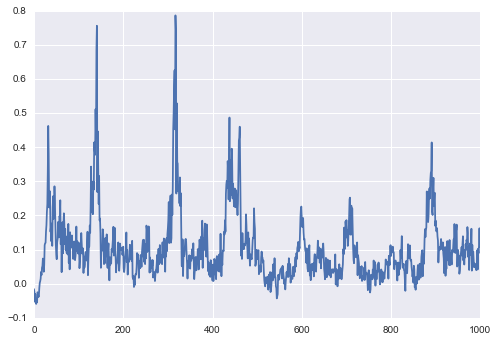


Model checkpoint saved to:
 /tmp/model/300rnn10--fc---2017-03-03--23-14-19/saver-1026
12600 val/sec: 4406	 it: 00001 sample_time: 6.734sec loss: 30.368870


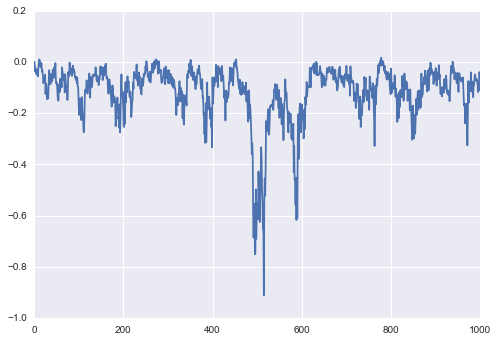

08400 val/sec: 3505	 it: 00002 sample_time: 6.690sec loss: 56.677891


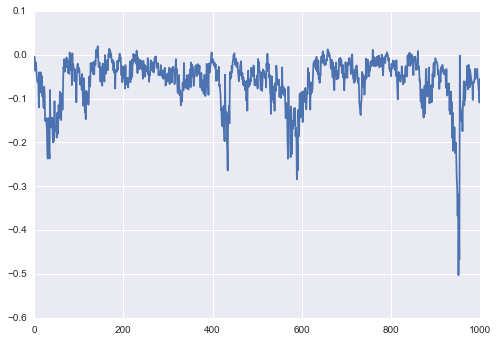

17400 val/sec: 2861	 it: 00003 sample_time: 11.567sec loss: 22.597307


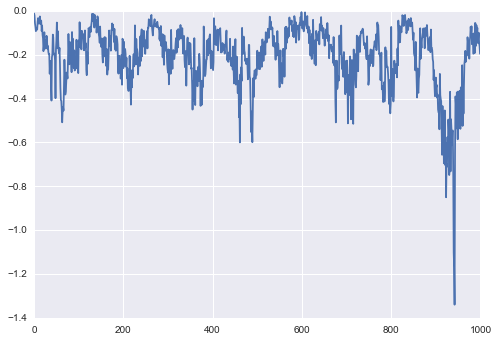

17400 val/sec: 1649	 it: 00004 sample_time: 9.626sec loss: 11.109419


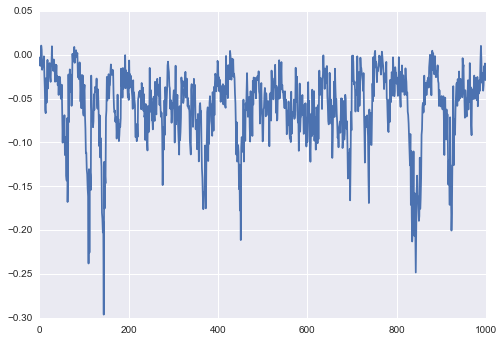

17400 val/sec: 1870	 it: 00005 sample_time: 9.079sec loss: 209.259186


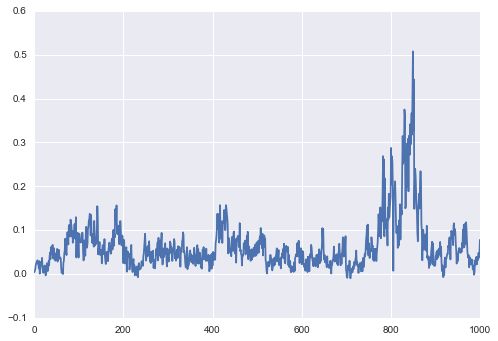

08400 val/sec: 2201	 it: 00006 sample_time: 6.432sec loss: 86.305054


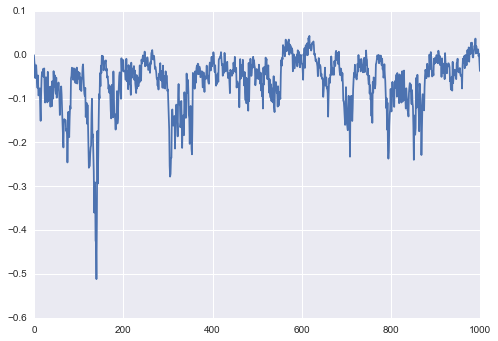

08400 val/sec: 2111	 it: 00007 sample_time: 5.716sec loss: 166.878601


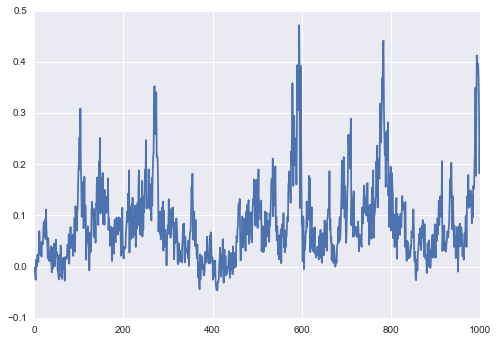

13200 val/sec: 3223	 it: 00008 sample_time: 8.321sec loss: 7.191682


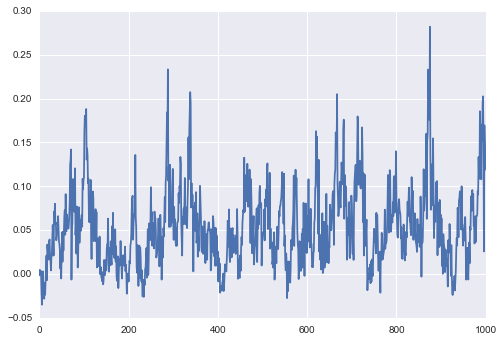

08400 val/sec: 2987	 it: 00009 sample_time: 5.693sec loss: 38.080383


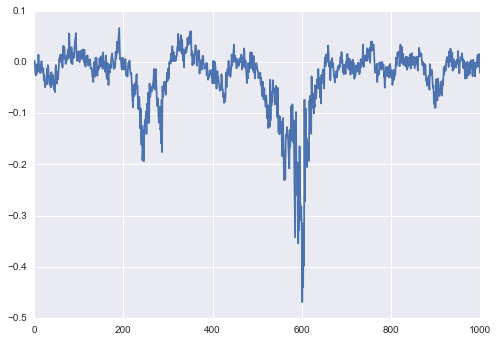

01200 val/sec: 3041

KeyboardInterrupt: 

In [12]:
for i, batch in enumerate(feeder):
    state = sess.run(g.zero_state)
    x_feed, label_feed, lens_feed = batch
    target_feed = np.roll(x_feed, 1) 
    
    start_time = time.time()
    for idx in range(0, lens_feed.max(), g.time_steps):
        data_window = x_feed[:, idx:idx+g.time_steps]
        target_window = target_feed[:, idx:idx+g.time_steps]
        lens_window = lens_feed-idx
        
        feed_dict = {
            g.x:data_window,
            g.init_state:state,
            g.seq_len:lens_window,
            target:target_window
        }
        
        
        fetch_dict = {
            'opt' : opt,
            'step' : global_step,
            'loss' : loss,
            'state' : g.rnn_last_states
        }
        start_window_time = time.time()
        fetch = sess.run(fetch_dict, feed_dict)
        window_time = time.time() - start_window_time
        valpsec = g.time_steps / window_time
        state = fetch['state']
        
        if idx % (2 * g.time_steps) == 0:
            sum_eval = sess.run(summaries, feed_dict)
            writer.add_summary(summary=sum_eval, global_step=fetch['step'])
            print('\r%05d val/sec: %d'%(idx, valpsec), end='', flush=True)
            
    sample_time = time.time() - start_time
    print('\t it: %05d sample_time: %03.3fsec loss: %f'%(i, sample_time, fetch['loss']))
    '''
    outputs = g.outputs.eval(init_feed_dict)
    plot = gen_plot(outputs, 3)
    feed_dict[plot_buf_placeholder] = plot
    writer.add_summary(im_sum.eval(feed_dict), global_step=fetch['step'])
    '''
    plt.show(plt.plot(eval(1000, sess)[0]))
    
    if i%20 == 0: 
        path = saver.save(sess, g.get_checkpoint_path()+'/saver', fetch['step'])
        print('\nModel checkpoint saved to:\n', path)
    
        

In [11]:
g.get_checkpoint_path()

'/tmp/model/1200rnn128--fc64---2017-03-02--02-55-04'

In [8]:
t = time.time()
time.sleep(3)
t = time.time() - t
t

3.0032777786254883

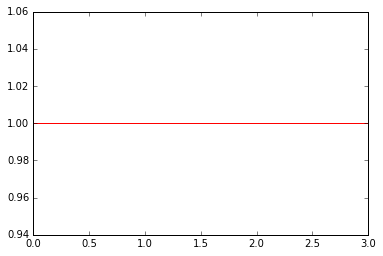

In [18]:
plt.clf()
plt.show(plt.plot(np.ones((4, 10))))